<a href="https://colab.research.google.com/github/TharinsaMudalige/Neuron-Brain_Tumor_Detection_Classification_with_XAI/blob/Image-Preprocesing/Grp_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [11]:
# Import Libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
import tensorflow as tf


In [12]:
# Import Libraries
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random

# Define preprocessing functions
def resize_image(image, target_size=(256, 256)):
    """
    Resize an image to the target size.
    """
    return cv2.resize(image, target_size)

def normalize_image(image):
    """
    Normalize pixel values to [0, 1].
    """
    return image / 255.0

def augment_image(image):
    """
    Apply random augmentation to an image.
    """
    # Random horizontal flip
    if random.random() > 0.5:
        image = np.fliplr(image)

    # Random rotation (between -10 and 10 degrees)
    angle = random.randint(-10, 10)
    h, w = image.shape
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, M, (w, h))

    return image

def preprocess_image(image, target_size=(256, 256), augment=False):
    """
    Preprocess an image (resize + normalize + optional augmentation).
    """
    image = resize_image(image, target_size)
    if augment:
        image = augment_image(image)
    image = normalize_image(image)
    return image

# Define dataset splitting function
def split_dataset(image_paths, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    """
    Split the dataset into training, validation, and test sets.
    """
    assert train_ratio + val_ratio + test_ratio == 1.0, "Ratios must sum to 1.0"

    # Split into training and temporary sets
    train_paths, temp_paths = train_test_split(image_paths, train_size=train_ratio, random_state=42)

    # Split temporary set into validation and test sets
    val_ratio_adjusted = val_ratio / (val_ratio + test_ratio)
    val_paths, test_paths = train_test_split(temp_paths, train_size=val_ratio_adjusted, random_state=42)

    return train_paths, val_paths, test_paths

# Define function to preprocess and save images
def preprocess_and_save(image_paths, output_dir, target_size=(256, 256), augment=False):
    """
    Preprocess a list of images and save them to the output directory.
    """
    os.makedirs(output_dir, exist_ok=True)
    for image_path in tqdm(image_paths):
        # Load image
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Warning: Could not read image {image_path}. Skipping.")
            continue

        # Preprocess image
        preprocessed_image = preprocess_image(image, target_size, augment)

        # Save preprocessed image
        output_path = os.path.join(output_dir, os.path.basename(image_path))
        cv2.imwrite(output_path, (preprocessed_image * 255).astype(np.uint8))

# Define function to preprocess the dataset while preserving the original structure
def preprocess_dataset(input_dir, output_dir, target_size=(256, 256), augment=False):
    """
    Preprocess the entire dataset and save it in the output directory while preserving the original structure.
    """
    # Collect all image paths
    image_paths = []
    for root, _, files in os.walk(input_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                image_paths.append(os.path.join(root, file))

    # Split dataset
    train_paths, val_paths, test_paths = split_dataset(image_paths)

    # Preprocess and save each split while preserving the original structure
    def save_images(paths, split_name):
        for path in paths:
            # Get the relative path to preserve the original structure
            relative_path = os.path.relpath(os.path.dirname(path), input_dir)
            output_subfolder = os.path.join(output_dir, split_name, relative_path)
            os.makedirs(output_subfolder, exist_ok=True)

            # Load and preprocess the image
            image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if image is None:
                print(f"Warning: Could not read image {path}. Skipping.")
                continue

            # Apply augmentation only for the training split
            preprocessed_image = preprocess_image(image, target_size, augment=(split_name == "train" and augment))

            # Save the preprocessed image
            output_path = os.path.join(output_subfolder, os.path.basename(path))
            cv2.imwrite(output_path, (preprocessed_image * 255).astype(np.uint8))

    # Save train, val, and test images
    save_images(train_paths, "train")
    save_images(val_paths, "val")
    save_images(test_paths, "test")

# Define input and output directories
input_dir = "/content/gdrive/MyDrive/Datasets"  # Your dataset directory
output_dir = "/content/gdrive/MyDrive/Preprocessed_Datasets"  # Directory to save preprocessed images

# Preprocess the dataset with augmentation for training only
preprocess_dataset(input_dir, output_dir, augment=True)

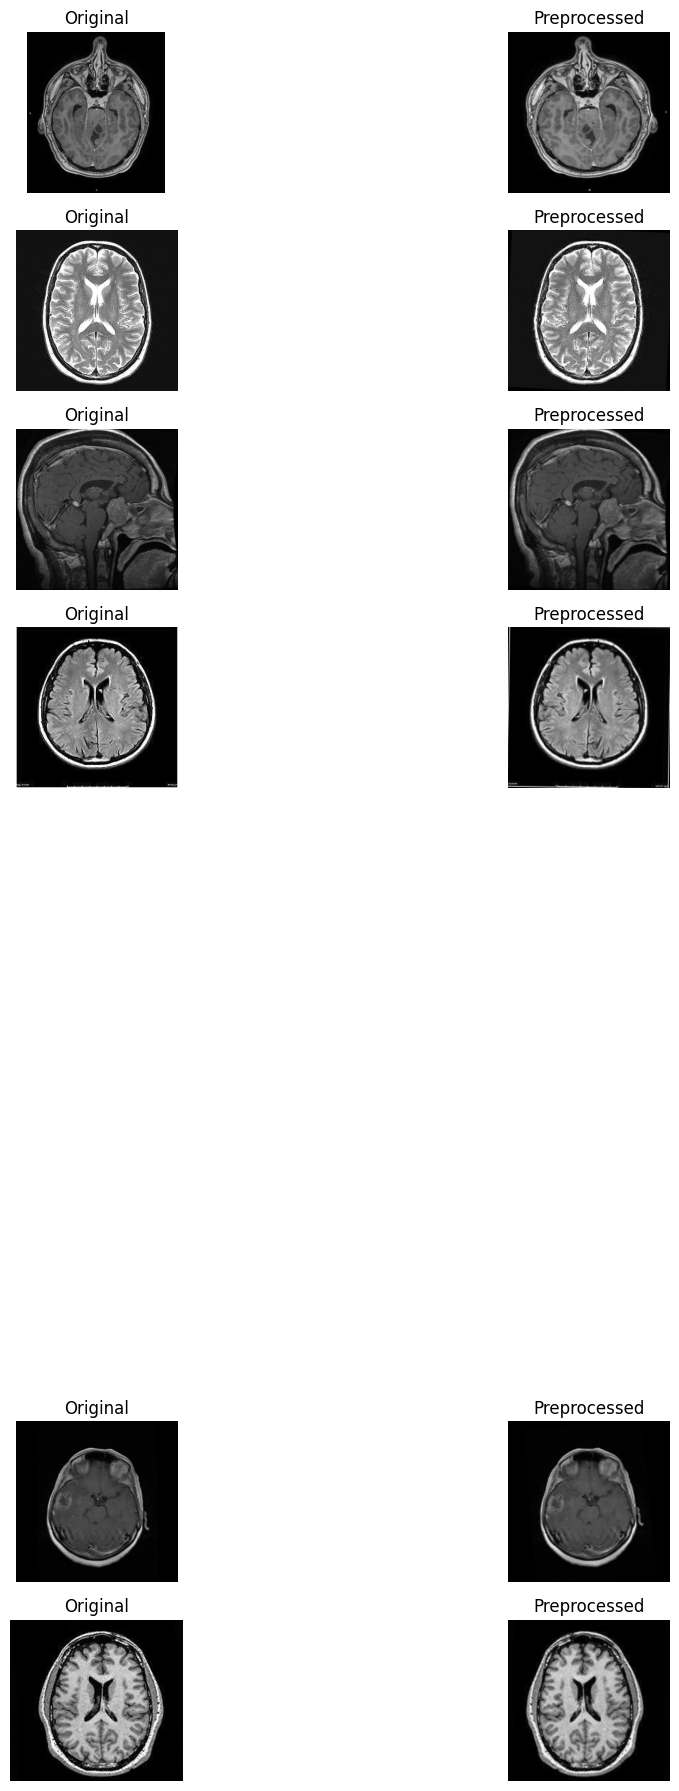

In [14]:
import matplotlib.pyplot as plt
import random
import cv2
import os

# Function to load and display 10 random original vs preprocessed images
def visualize_preprocessing(original_dir, preprocessed_dir, num_samples=10):

    # Collect all image paths
    original_images = []
    for root, _, files in os.walk(original_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif')):
                original_images.append(os.path.join(root, file))

    # Randomly select 'num_samples' images
    random_samples = random.sample(original_images, num_samples)

    plt.figure(figsize=(10, 20))

    for i, original_path in enumerate(random_samples):
        # Load original image
        original_image = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)

        # Get corresponding preprocessed image path
        preprocessed_path = os.path.join(preprocessed_dir,
                                         os.path.relpath(original_path, original_dir))

        # Check if preprocessed image exists
        if not os.path.exists(preprocessed_path):
            print(f"Warning: Preprocessed image not found: {preprocessed_path}. Skipping.")
            continue

        # Load preprocessed image
        preprocessed_image = cv2.imread(preprocessed_path, cv2.IMREAD_GRAYSCALE)

        # Check if image was loaded successfully
        if preprocessed_image is None:
            print(f"Warning: Could not read preprocessed image: {preprocessed_path}. Skipping.")
            continue

        # Plot original image
        plt.subplot(num_samples, 2, 2 * i + 1)
        plt.imshow(original_image, cmap='gray')
        plt.title("Original")
        plt.axis("off")

        # Plot preprocessed image
        plt.subplot(num_samples, 2, 2 * i + 2)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.title("Preprocessed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Define my dataset paths
original_dataset_dir = "/content/gdrive/MyDrive/Datasets"  # Original images directory
preprocessed_dataset_dir = "/content/gdrive/MyDrive/Preprocessed_Datasets/train"  # Preprocessed images directory

# Call function to visualize
visualize_preprocessing(original_dataset_dir, preprocessed_dataset_dir)
